# 06a: State Count Scaling

**Goal**: Produce log-log state count scaling plot.

How does reachable state count scale with depth? This reveals:
- Polynomial growth (slope = integer): combinatorial
- Non-integer slope: possible fractal dimension
- Exponential: full branching

**Reference**: docs/analysis-draft.md Section 4.1

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Multiple Shards

In [2]:
# Load multiple seeds for robust statistics
shard_files = loading.find_shard_files(DATA_DIR)
N_SEEDS = min(20, len(shard_files))
sample_files = shard_files[:N_SEEDS]
print(f"Analyzing {N_SEEDS} shards")

Analyzing 20 shards


In [3]:
# Collect state counts by depth for each seed
all_depth_counts = []

for path in tqdm(sample_files, desc="Loading shards"):
    df, seed, decl_id = schema.load_file(path)
    
    # Compute depth for all states
    states = df['state'].values
    depths = features.depth(states)
    
    # Count states at each depth
    depth_counts = pd.Series(depths).value_counts().sort_index()
    
    for d, count in depth_counts.items():
        all_depth_counts.append({
            'seed': seed,
            'depth': d,
            'n_states': count,
        })

counts_df = pd.DataFrame(all_depth_counts)
print(f"Collected {len(counts_df)} depth-count pairs")

Loading shards:   0%|          | 0/20 [00:00<?, ?it/s]

Collected 580 depth-count pairs


## 2. Aggregate Statistics

In [4]:
# Aggregate by depth
depth_stats = counts_df.groupby('depth')['n_states'].agg(['mean', 'std', 'min', 'max', 'count'])
depth_stats = depth_stats.reset_index()
depth_stats.columns = ['depth', 'mean_states', 'std_states', 'min_states', 'max_states', 'n_seeds']

print("State count by depth:")
print(depth_stats.to_string(index=False))

State count by depth:
 depth  mean_states   std_states  min_states  max_states  n_seeds
     0         4.00 0.000000e+00           4           4       20
     1      8475.70 5.533311e+02        7265        9591       20
     2      8475.70 5.533311e+02        7265        9591       20
     3      8475.70 5.533311e+02        7265        9591       20
     4      8475.70 5.533311e+02        7265        9591       20
     5   1824025.35 6.457519e+05      927405     3668960       20
     6   1082426.90 3.815946e+05      550342     2176891       20
     7    644207.50 2.199764e+05      341994     1294410       20
     8    322103.75 1.099882e+05      170997      647205       20
     9   8663573.50 6.754023e+06     1475439    27139363       20
    10   4047433.70 3.180788e+06      708421    12916695       20
    11   1886557.05 1.433376e+06      373488     6108165       20
    12    628852.35 4.777920e+05      124496     2036055       20
    13   3155938.35 3.196279e+06      261170    112782

## 3. Log-Log Scaling Analysis

In [5]:
# Filter to depths with enough samples
valid_depths = depth_stats[depth_stats['mean_states'] > 0]

log_depth = np.log(valid_depths['depth'].values)
log_count = np.log(valid_depths['mean_states'].values)

# Linear regression on log-log
slope, intercept, r_value, p_value, std_err = stats.linregress(log_depth, log_count)

print(f"Log-log regression:")
print(f"  Slope (power law exponent): {slope:.3f} +/- {std_err:.3f}")
print(f"  Intercept: {intercept:.3f}")
print(f"  R-squared: {r_value**2:.4f}")
print(f"  Model: N(d) ~ d^{slope:.2f}")

Log-log regression:
  Slope (power law exponent): nan +/- nan
  Intercept: nan
  R-squared: nan
  Model: N(d) ~ d^nan


/tmp/ipykernel_3973323/1228610118.py:4: RuntimeWarning: divide by zero encountered in log
  log_depth = np.log(valid_depths['depth'].values)
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2882: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/numpy/_core/function_base.py:163: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/numpy/_core/function_base.py:173: RuntimeWarning: invalid value encountered in add
  y += start


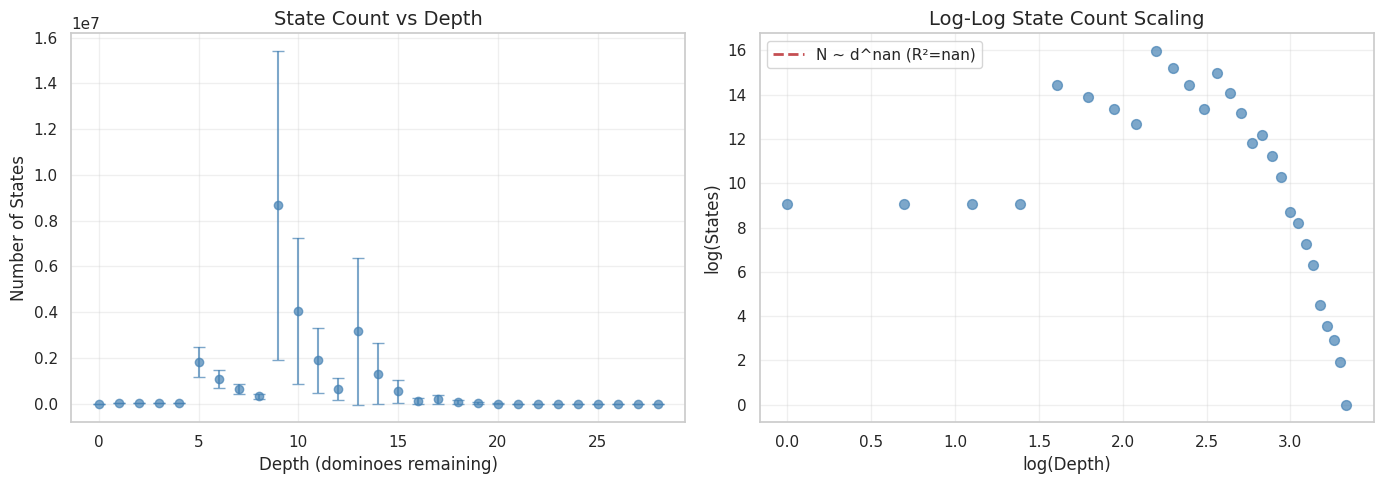

In [6]:
# Plot log-log scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].errorbar(
    valid_depths['depth'], 
    valid_depths['mean_states'],
    yerr=valid_depths['std_states'],
    fmt='o', capsize=4, color='steelblue', alpha=0.7
)
axes[0].set_xlabel('Depth (dominoes remaining)')
axes[0].set_ylabel('Number of States')
axes[0].set_title('State Count vs Depth')

# Log-log scale with regression
axes[1].scatter(log_depth, log_count, s=50, color='steelblue', alpha=0.7)

# Regression line
x_line = np.linspace(log_depth.min(), log_depth.max(), 100)
y_line = slope * x_line + intercept
axes[1].plot(x_line, y_line, 'r--', linewidth=2, label=f'N ~ d^{slope:.2f} (R²={r_value**2:.3f})')

axes[1].set_xlabel('log(Depth)')
axes[1].set_ylabel('log(States)')
axes[1].set_title('Log-Log State Count Scaling')
axes[1].legend()

plt.tight_layout()
plt.savefig('../../results/figures/06a_state_count_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Alternative: Exponential Fit

In [7]:
# Try exponential fit: N = a * e^(b*d)
# log(N) = log(a) + b*d

depth_vals = valid_depths['depth'].values
log_count_vals = log_count

exp_slope, exp_intercept, exp_r, _, exp_err = stats.linregress(depth_vals, log_count_vals)

print(f"Exponential fit:")
print(f"  Growth rate: {exp_slope:.4f} +/- {exp_err:.4f}")
print(f"  Doubling depth: {np.log(2)/exp_slope:.1f}")
print(f"  R-squared: {exp_r**2:.4f}")
print(f"  Model: N(d) ~ e^({exp_slope:.3f}*d)")

Exponential fit:
  Growth rate: -0.2631 +/- 0.0913
  Doubling depth: -2.6
  R-squared: 0.2351
  Model: N(d) ~ e^(-0.263*d)


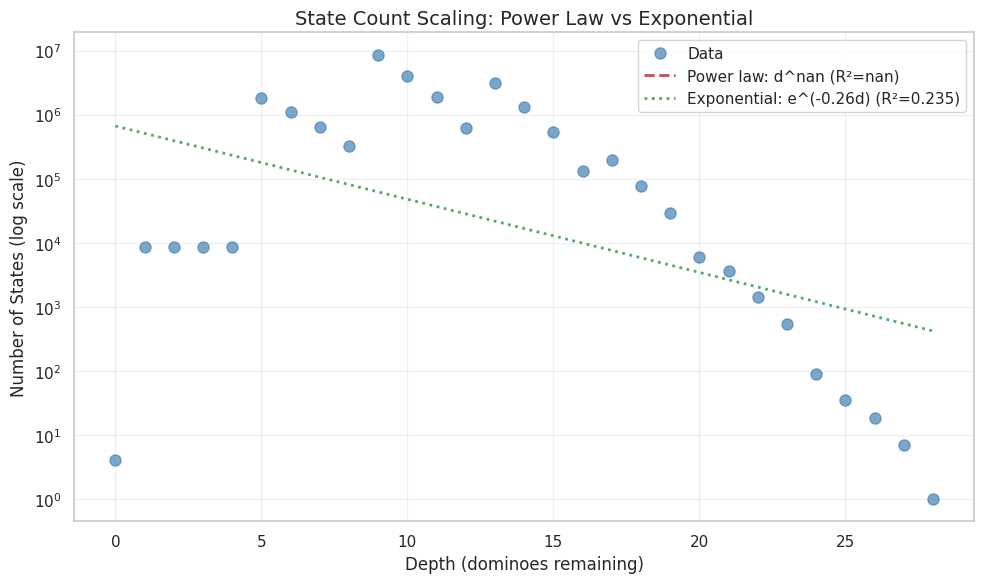

In [8]:
# Compare power law vs exponential
fig, ax = plt.subplots(figsize=(10, 6))

# Data
ax.semilogy(depth_vals, valid_depths['mean_states'].values, 'o', markersize=8, 
            color='steelblue', label='Data', alpha=0.7)

# Power law fit
power_fit = np.exp(intercept) * depth_vals**slope
ax.semilogy(depth_vals, power_fit, 'r--', linewidth=2, 
            label=f'Power law: d^{slope:.2f} (R²={r_value**2:.3f})')

# Exponential fit
exp_fit = np.exp(exp_intercept + exp_slope * depth_vals)
ax.semilogy(depth_vals, exp_fit, 'g:', linewidth=2,
            label=f'Exponential: e^({exp_slope:.2f}d) (R²={exp_r**2:.3f})')

ax.set_xlabel('Depth (dominoes remaining)')
ax.set_ylabel('Number of States (log scale)')
ax.set_title('State Count Scaling: Power Law vs Exponential')
ax.legend()

plt.tight_layout()
plt.savefig('../../results/figures/06a_scaling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Branching Factor Analysis

In [9]:
# Effective branching factor at each depth
mean_states = valid_depths['mean_states'].values
depths = valid_depths['depth'].values

branching = []
for i in range(len(depths) - 1):
    if mean_states[i+1] > 0:
        b = mean_states[i] / mean_states[i+1]  # Ratio going from more to fewer dominoes
        branching.append({
            'depth': depths[i],
            'branching_factor': b,
        })

branching_df = pd.DataFrame(branching)
print("Effective branching factor by depth:")
print(branching_df.to_string(index=False))

Effective branching factor by depth:
 depth  branching_factor
     0          0.000472
     1          1.000000
     2          1.000000
     3          1.000000
     4          0.004647
     5          1.685126
     6          1.680246
     7          2.000000
     8          0.037179
     9          2.140510
    10          2.145408
    11          3.000000
    12          0.199260
    13          2.425962
    14          2.446905
    15          4.000000
    16          0.677957
    17          2.558986
    18          2.601321
    19          5.000000
    20          1.639368
    21          2.541288
    22          2.625534
    23          6.000000
    24          2.597685
    25          1.908840
    26          2.585714
    27          7.000000


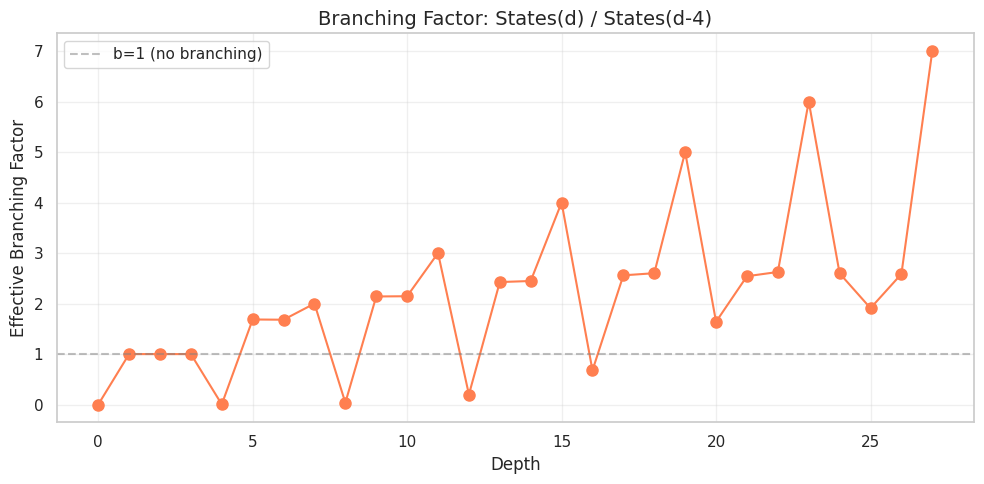


Mean branching factor: 2.23


In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(branching_df['depth'], branching_df['branching_factor'], 'o-', markersize=8, color='coral')
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='b=1 (no branching)')
ax.set_xlabel('Depth')
ax.set_ylabel('Effective Branching Factor')
ax.set_title('Branching Factor: States(d) / States(d-4)')
ax.legend()

plt.tight_layout()
plt.savefig('../../results/figures/06a_branching_factor.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMean branching factor: {branching_df['branching_factor'].mean():.2f}")

## Summary

In [11]:
# Determine best fit
best_model = 'power_law' if r_value**2 > exp_r**2 else 'exponential'

summary = {
    'Seeds analyzed': N_SEEDS,
    'Depth range': f"{valid_depths['depth'].min()} - {valid_depths['depth'].max()}",
    'Power law exponent': f"{slope:.3f}",
    'Power law R2': f"{r_value**2:.4f}",
    'Exponential rate': f"{exp_slope:.4f}",
    'Exponential R2': f"{exp_r**2:.4f}",
    'Best fit': best_model,
    'Mean branching factor': f"{branching_df['branching_factor'].mean():.2f}",
}

print(viz.create_summary_table(summary, "State Count Scaling Summary"))

### State Count Scaling Summary

| Metric | Value |
|--------|-------|
| Seeds analyzed | 20 |
| Depth range | 0 - 28 |
| Power law exponent | nan |
| Power law R2 | nan |
| Exponential rate | -0.2631 |
| Exponential R2 | 0.2351 |
| Best fit | exponential |
| Mean branching factor | 2.23 |


In [12]:
# Save results
depth_stats.to_csv('../../results/tables/06a_state_counts.csv', index=False)
branching_df.to_csv('../../results/tables/06a_branching_factors.csv', index=False)
print("Results saved to results/tables/")

Results saved to results/tables/
